# Julia is Fast - `@time`, `@elapsed` and `@inbounds`


In this notebook, we demonstrate how fast `Julia` is, compared to other dynamically typed languages. 

## Prerequisites

Read the text [Why Julia?](https://github.com/stevengj/julia-mit/blob/master/README.md#why-julia) (3 min)

Read [Performance tips](https://docs.julialang.org/en/latest/manual/performance-tips/) section of the `Julia` manual. (20 min) 

## Competences 

The reader should understand effects of "[just-in-time
compiler](https://en.wikipedia.org/wiki/Just-in-time_compilation)"
called [LLVM](http://llvm.org/) on the speed of execution of programs. 
The reader should be able to write simple, but fast, programs containing loops.

## Credits 

Some examples are taken from [The Julia Manual](https://docs.julialang.org/en/latest/).


## Scholarly example - summing integer halves

Consider the function `f` which sums halves of integers from `1` to `n`:

__N.B.__ `Esc l` toggles line numbers in the current cell.

In [1]:
function f(n)
    s = 0
    for i = 1:n
        s += i/2
    end
    s
end

f (generic function with 1 method)

In order for the fast execution, the function must first be compiled. Compilation is performed automatically, when the function is invoked for the first time. Therefore, the first call can be done with some trivial choice of parameters.

The timing can be done by two commands, `@time` and `@elapsed`: 

In [2]:
?@time

```
@time
```

A macro to execute an expression, printing the time it took to execute, the number of allocations, and the total number of bytes its execution caused to be allocated, before returning the value of the expression.

See also [`@timev`](@ref), [`@timed`](@ref), [`@elapsed`](@ref), and [`@allocated`](@ref).

```julia-repl
julia> @time rand(10^6);
  0.001525 seconds (7 allocations: 7.630 MiB)

julia> @time begin
           sleep(0.3)
           1+1
       end
  0.301395 seconds (8 allocations: 336 bytes)
2
```


In [3]:
?@elapsed

```
@elapsed
```

A macro to evaluate an expression, discarding the resulting value, instead returning the number of seconds it took to execute as a floating-point number.

See also [`@time`](@ref), [`@timev`](@ref), [`@timed`](@ref), and [`@allocated`](@ref).

```julia-repl
julia> @elapsed sleep(0.3)
0.301391426
```


In [4]:
@time f(1) 

  0.020063 seconds (26.65 k allocations: 1.425 MiB)


0.5

In [5]:
@elapsed f(1)  # This run is much faster, since the function is already compiled

2.4e-6

Let us now run the big-size computation. Notice the unnaturally high byte allocation and the huge amount of time spent on 
[garbage collection](http://en.wikipedia.org/wiki/Garbage_collection_%28computer_science%29).

In [6]:
@time f(1_000_000) # s is cpnverted to Float64

  0.001247 seconds (5 allocations: 176 bytes)


2.5000025e11

This comment is now obsolete 

> Since your computer can execute several _Gigaflops_ (floating-point operations per second), this is rather slow. This slowness is due to _type instability_: variable `s` is in the beginning assumed to be of type `Integer`, while at every other step, the result is a real number of type `Float64`. Permanent checking of types requires permanent memory allocation and deallocation (garbage collection). This is corrected by very simple means: just declare `s` as a real number, and the execution is more than 10 times faster with almost no memory allocation (and, consequently, no garbage collection).

In [7]:
function f1(n)
    s = 0.0
    for i = 1:n
        s += i/2
    end
    s
end

f1 (generic function with 1 method)

In [8]:
@time f1(1)

  0.011597 seconds (16.14 k allocations: 879.280 KiB)


0.5

In [9]:
@time f1(1_000_000)

  0.001231 seconds (5 allocations: 176 bytes)


2.5000025e11

`@time` can alo be invoked as a function:

In [10]:
@time(f1(1_000_000))

  0.001144 seconds (5 allocations: 176 bytes)


2.5000025e11

In [11]:
@time s2=f1(1_000_000)

  0.001269 seconds (6 allocations: 224 bytes)


2.5000025e11

In [12]:
@time(s2=f1(1_000_000))

  0.001093 seconds (5 allocations: 176 bytes)


2.5000025e11

## Real-world example - exponential moving average

[Exponential moving average](http://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) is a fast _one pass_ formula (each data point of the given data set $A$ is accessed only once) often used in high-frequency on-line trading (see [Online Algorithms in High-Frequency Trading](http://cacm.acm.org/magazines/2013/10/168184-online-algorithms-in-high-frequency-trading/fulltext) for more details). __Notice that the output array $X$ is declared in advance.__

Using `return` in the last line is here optional.


In [13]:
function fexpma( A::Vector{T}, α::T ) where T
# fast exponential moving average: X - moving average, 
# A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array{T}(undef,n) # Declare empty X
    β = one(T)-α
    X[1] = A[1]
    for k = 2:n
        X[k] = β*A[k] + α*X[k-1]
    end
    return X
end


fexpma (generic function with 1 method)

In [14]:
fexpma([1.0],0.5) # First run for compilation

1-element Array{Float64,1}:
 1.0

We now generate some big-size data:

In [15]:
# Big random slightly increasing sequence
A=[rand() + 0.00001*k*rand() for k=1:20_000_000]

20000000-element Array{Float64,1}:
   0.4781596200369279 
   0.44006574727191344
   0.19573885526579907
   0.8192557290407604 
   0.4355195572039746 
   0.03650817098990099
   0.15848148681307747
   0.6089668607948314 
   0.05052008669718134
   0.9564312259878632 
   0.5793059709869757 
   0.5474672528133186 
   0.05259926485984266
   ⋮                  
 190.8303014225308    
 115.37856626748001   
  11.585756899332024  
  69.07553820916121   
 189.39872250148946   
  69.05273893837942   
  64.31450113544241   
 176.17704909541968   
 149.56634451546913   
 102.95572912871484   
   5.00380322771152   
 165.34591350315478   

In [17]:
@time X=fexpma(A,0.9)

  0.202943 seconds (6 allocations: 152.588 MiB, 32.21% gc time)


20000000-element Array{Float64,1}:
   0.4781596200369279 
   0.4743502327604265 
   0.44648909501096373
   0.4837657584139434 
   0.47894113829294654
   0.434697841562642  
   0.4070762060876856 
   0.42726527155840016
   0.38959075307227825
   0.4462748003638367 
   0.4595779174261506 
   0.4683668509648674 
   0.42679009235436494
   ⋮                  
  94.05138149625526   
  96.18409997337773   
  87.72426566597316   
  85.85939292029197   
  96.21332587841171   
  93.49726718440849   
  90.57899057951188   
  99.13879643110266   
 104.1815512395393    
 104.05896902845686   
  94.15345244838232   
 101.27269855385956   

## `@inbounds`

The `@inbounds` command eliminates array bounds checking within expressions. Be certain before doing this. If the subscripts are ever out of bounds, you may suffer crashes or silent corruption. The following program runs a little faster:

In [18]:
function fexpma( A::Vector{T}, α::T ) where T
# fast exponential moving average: X - moving average, 
# A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array{T}(undef,n) # Declare X
    β = one(T)-α
    X[1] = A[1]
    @inbounds for k = 2:n
        X[k] = β*A[k] + α*X[k-1]
    end
    return X
end

fexpma (generic function with 1 method)

In [20]:
@time X=fexpma(A,0.9)

  0.142801 seconds (6 allocations: 152.588 MiB, 43.71% gc time)


20000000-element Array{Float64,1}:
   0.4781596200369279 
   0.4743502327604265 
   0.44648909501096373
   0.4837657584139434 
   0.47894113829294654
   0.434697841562642  
   0.4070762060876856 
   0.42726527155840016
   0.38959075307227825
   0.4462748003638367 
   0.4595779174261506 
   0.4683668509648674 
   0.42679009235436494
   ⋮                  
  94.05138149625526   
  96.18409997337773   
  87.72426566597316   
  85.85939292029197   
  96.21332587841171   
  93.49726718440849   
  90.57899057951188   
  99.13879643110266   
 104.1815512395393    
 104.05896902845686   
  94.15345244838232   
 101.27269855385956   

Similar `Matlab` programs give the following timing for the two versions of the function, first _without_ prior declaration of $X$ and then _with_ prior declaration. The _latter_ version is several times faster, but still slow. 

---
```
function X = fexpma0( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> A=rand(20000000,1)+0.00001*[1:20000000]'.*rand(20000000,1);
>> tic, X=fexpma0(A,0.9); toc
Elapsed time is 3.073359 seconds.
```

---

```
function X = fexpma( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
X=zeros(n,1); % Allocate X in advance
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> tic, X=fexpma(A,0.9); toc
Elapsed time is 0.320976 seconds.
```

## Plotting the moving average

Let us plot the data $A$ and its exponential moving average $X$. The dimension of the data is too large for meaningful direct plot. In `Julia` we can use `@manipulate` command to slide through the data. It takes a while to read packages `Gadfly` (for plotting) and `Interact`, which is needed only for the first invocation.

In [21]:
using Gadfly

┌ Info: Recompiling stale cache file /mnt/juliabox/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190


In [22]:
using Interact

┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1192


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/70234be257fdbf3c7a34dd83b4dd818d3f7bd0eb-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/70234be257fdbf3c7a34dd83b4dd818d3f7bd0eb-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

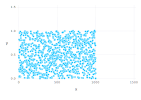

In [23]:
k=1
plot(x=collect(k:k+1000),y=A[k:k+1000])

In [24]:
@manipulate for k=1:1000:20000000
    plot(layer(x=collect(k:k+1000),y=A[k:k+1000],Geom.point),
        layer(x=collect(k:k+1000),y=X[k:k+1000],Geom.line,Theme(default_color=colorant"red")))
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:k=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
9999001), Observable{Int64} with 2 listeners. Value:
9999001, Scope("knockout-component-64c93642-eae7-43f0-8b3e-a0a1ef184bc2", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["k"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>19999001,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1000,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
9999001, nothing)), Set(String[]), nothing, Any["knockout"=>"/home/jrun/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/home/jrun/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/home/jrun/.julia/packages/InteractBase/3SqBl/src/../assets/all.js", "/home/jrun/.julia/packages/InteractBase/3SqBl/src/../assets/style.css", "/home/jrun/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":9999001}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-64c93642-eae7-43f0-8b3e-a0a1ef184bc2\",\"id\":\"ob_02\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-64c93642-eae7-43f0-8b3e-a0a1ef184bc2\",\"id\":\"ob_01\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"value\"]=false}),self)]\n        \n    }\n  

### Remark
More details about optimizing your programs are given in the [Profiling Notebook](http://localhost:8890/notebooks/Documents/Julia/Julia-Course/src/05%20Profiling.ipynb).

## Pre-allocating output

The following example is from [Pre-allocating outputs](https://docs.julialang.org/en/stable/manual/performance-tips/#Pre-allocating-outputs-1). The functions `loopinc()` and `loopinc_prealloc()` both compute $\sum_{i=2}^{10000001}i$, the second one being 15 times faster: 

In [25]:
function xinc(x)
    return [x, x+1, x+2]
end

function loopinc()
    y = 0
    for i = 1:10^7
        ret = xinc(i)
        y += ret[2]
    end
    y
end

function xinc!(ret::AbstractVector{T}, x::T) where T
    ret[1] = x
    ret[2] = x+1
    ret[3] = x+2
    nothing
end

function loopinc_prealloc()
    ret = Array{Int}(undef,3)
    y = 0
    for i = 1:10^7
        xinc!(ret, i)
        y += ret[2]
    end
    y
end

loopinc_prealloc (generic function with 1 method)

In [27]:
@time loopinc()

  0.888213 seconds (40.00 M allocations: 1.490 GiB, 38.84% gc time)


50000015000000

In [29]:
@time loopinc_prealloc() # After the second run

  0.010397 seconds (6 allocations: 288 bytes)


50000015000000

## Memory access

The following example is from [Access arrays in memory order, along columns](https://docs.julialang.org/en/stable/manual/performance-tips/#Access-arrays-in-memory-order,-along-columns-1).

Multidimensional arrays in Julia are stored in column-major order, which means that arrays are stacked one column at a time. This convention for ordering arrays is common in many languages like Fortran, Matlab, and R (to name a few). The alternative to column-major ordering is row-major ordering, which is the convention adopted by C and Python (numpy) among other languages. The ordering can be verified using the `vec()` function or the syntax `[:]`:

In [30]:
# Set the seed for the random number generator
import Random
Random.seed!(123)
B = rand(0:9,4,3)

4×3 Array{Int64,2}:
 4  8  4
 2  7  1
 1  7  7
 9  7  3

In [31]:
B[:]

12-element Array{Int64,1}:
 4
 2
 1
 9
 8
 7
 7
 7
 4
 1
 7
 3

In [32]:
vec(B)

12-element Array{Int64,1}:
 4
 2
 1
 9
 8
 7
 7
 7
 4
 1
 7
 3

The ordering of arrays can have significant performance effects when looping over arrays. Loops should be organized such that the subsequent accessed elements are close to each other in physical memory.

The following functions accept a `Vector` and and return a square `Array` with the rows or the columns filled with copies of the input vector, respectively.

In [33]:
function copy_cols(x::Vector{T}) where T
    n = size(x, 1)
    out = Array{eltype(x)}(undef,n, n)
    for i=1:n
        out[:, i] = x
    end
    out
end

function copy_rows(x::Vector{T}) where T
    n = size(x, 1)
    out = Array{eltype(x)}(undef,n, n)
    for i=1:n
        out[i, :] = x
    end
    out
end

copy_rows (generic function with 1 method)

In [34]:
copy_cols([1.0,2])
copy_rows([1.0,2])

2×2 Array{Float64,2}:
 1.0  2.0
 1.0  2.0

In [35]:
x=rand(5000) # generate a random vector

5000-element Array{Float64,1}:
 0.3175641101318034   
 0.28677406854345056  
 0.7020914202653514   
 0.4978045541730767   
 0.06288737315383153  
 0.8172614762257204   
 0.41246432358844354  
 0.44959910416309845  
 0.0020647396028048437
 0.5138344508360293   
 0.9576873771082626   
 0.22639731616123138  
 0.6342070799721164   
 ⋮                    
 0.09143297925761962  
 0.8265564915121488   
 0.16177249940502847  
 0.06470205727455447  
 0.22871236376036652  
 0.556913457304788    
 0.578843623826564    
 0.5243372527452201   
 0.5123207296427339   
 0.8269323285749814   
 0.7058603316467515   
 0.29197826680025996  

In [37]:
@time C=copy_cols(x)  # We generate a large matrix

  0.085946 seconds (6 allocations: 190.735 MiB, 11.70% gc time)


5000×5000 Array{Float64,2}:
 0.317564    0.317564    0.317564    …  0.317564    0.317564    0.317564  
 0.286774    0.286774    0.286774       0.286774    0.286774    0.286774  
 0.702091    0.702091    0.702091       0.702091    0.702091    0.702091  
 0.497805    0.497805    0.497805       0.497805    0.497805    0.497805  
 0.0628874   0.0628874   0.0628874      0.0628874   0.0628874   0.0628874 
 0.817261    0.817261    0.817261    …  0.817261    0.817261    0.817261  
 0.412464    0.412464    0.412464       0.412464    0.412464    0.412464  
 0.449599    0.449599    0.449599       0.449599    0.449599    0.449599  
 0.00206474  0.00206474  0.00206474     0.00206474  0.00206474  0.00206474
 0.513834    0.513834    0.513834       0.513834    0.513834    0.513834  
 0.957687    0.957687    0.957687    …  0.957687    0.957687    0.957687  
 0.226397    0.226397    0.226397       0.226397    0.226397    0.226397  
 0.634207    0.634207    0.634207       0.634207    0.634207    0.634207

In [39]:
@time D=copy_rows(x) # This is few times slower

  0.334190 seconds (6 allocations: 190.735 MiB, 44.81% gc time)


5000×5000 Array{Float64,2}:
 0.317564  0.286774  0.702091  0.497805  …  0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805  …  0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805  …  0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 ⋮                                  

### Remark
There is also a built-in function `repeat()`:

In [40]:
?repeat

search: repeat prepare_display



```
repeat(A::AbstractArray, counts::Integer...)
```

Construct an array by repeating array `A` a given number of times in each dimension, specified by `counts`.

# Examples

```jldoctest
julia> repeat([1, 2, 3], 2)
6-element Array{Int64,1}:
 1
 2
 3
 1
 2
 3

julia> repeat([1, 2, 3], 2, 3)
6×3 Array{Int64,2}:
 1  1  1
 2  2  2
 3  3  3
 1  1  1
 2  2  2
 3  3  3
```

---

```
repeat(A::AbstractArray; inner=ntuple(x->1, ndims(A)), outer=ntuple(x->1, ndims(A)))
```

Construct an array by repeating the entries of `A`. The i-th element of `inner` specifies the number of times that the individual entries of the i-th dimension of `A` should be repeated. The i-th element of `outer` specifies the number of times that a slice along the i-th dimension of `A` should be repeated. If `inner` or `outer` are omitted, no repetition is performed.

# Examples

```jldoctest
julia> repeat(1:2, inner=2)
4-element Array{Int64,1}:
 1
 1
 2
 2

julia> repeat(1:2, outer=2)
4-element Array{Int64,1}:
 1
 2
 1
 2

julia> repeat([1 2; 3 4], inner=(2, 1), outer=(1, 3))
4×6 Array{Int64,2}:
 1  2  1  2  1  2
 1  2  1  2  1  2
 3  4  3  4  3  4
 3  4  3  4  3  4
```

---

```
repeat(s::AbstractString, r::Integer)
```

Repeat a string `r` times. This can be written as `s^r`.

See also: [`^`](@ref)

# Examples

```jldoctest
julia> repeat("ha", 3)
"hahaha"
```

---

```
repeat(c::AbstractChar, r::Integer) -> String
```

Repeat a character `r` times. This can equivalently be accomplished by calling [`c^r`](@ref ^).

# Examples

```jldoctest
julia> repeat('A', 3)
"AAA"
```


In [43]:
@time C1=repeat(x,1,5000)

  0.081117 seconds (6 allocations: 190.735 MiB, 7.24% gc time)


5000×5000 Array{Float64,2}:
 0.317564    0.317564    0.317564    …  0.317564    0.317564    0.317564  
 0.286774    0.286774    0.286774       0.286774    0.286774    0.286774  
 0.702091    0.702091    0.702091       0.702091    0.702091    0.702091  
 0.497805    0.497805    0.497805       0.497805    0.497805    0.497805  
 0.0628874   0.0628874   0.0628874      0.0628874   0.0628874   0.0628874 
 0.817261    0.817261    0.817261    …  0.817261    0.817261    0.817261  
 0.412464    0.412464    0.412464       0.412464    0.412464    0.412464  
 0.449599    0.449599    0.449599       0.449599    0.449599    0.449599  
 0.00206474  0.00206474  0.00206474     0.00206474  0.00206474  0.00206474
 0.513834    0.513834    0.513834       0.513834    0.513834    0.513834  
 0.957687    0.957687    0.957687    …  0.957687    0.957687    0.957687  
 0.226397    0.226397    0.226397       0.226397    0.226397    0.226397  
 0.634207    0.634207    0.634207       0.634207    0.634207    0.634207

In [45]:
@time C1=repeat(transpose(x),5000,1)

  0.319540 seconds (7 allocations: 190.735 MiB, 41.56% gc time)


5000×5000 Array{Float64,2}:
 0.317564  0.286774  0.702091  0.497805  …  0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805  …  0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805  …  0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 0.317564  0.286774  0.702091  0.497805     0.826932  0.70586  0.291978
 ⋮                                  